# Prediction of number of infractions using 1D CNNs

In [1]:
# Import Libraries
from math import floor
import pandas as pd
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from matplotlib import pyplot
from numpy import mean, std
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder

## Tickets dataset

In [2]:
# O ficheiro é demasiado grande para o github
df = pd.read_csv('/home/fabio/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                 parse_dates=['EntryDate'])
df

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1300 ROBSON ST


## Geodata dataset

In [3]:
streets_df = gpd.read_file('public-streets.geojson')
streets_df.head(10)

,streetuse,hblock,geometry
0,Residential,2300 E 11TH AV,"LINESTRING (-123.05819 49.26038, -123.05743 49..."
1,Residential,5500-5600 INVERNESS ST,"LINESTRING (-123.07978 49.23318, -123.07980 49..."
2,Residential,700 DURWARD AV,"LINESTRING (-123.08965 49.24086, -123.08795 49..."
3,Residential,300 DUNLEVY AV,"LINESTRING (-123.09534 49.28221, -123.09536 49..."
4,Residential,300 GORE AV,"LINESTRING (-123.09754 49.28179, -123.09747 49..."
5,Arterial,300 E HASTINGS ST,"LINESTRING (-123.09747 49.28129, -123.09538 49..."
6,Residential,300 SALSBURY DRIVE,"LINESTRING (-123.06826 49.28171, -123.06826 49..."
7,Residential,400 HAWKS AV,"LINESTRING (-123.08716 49.28110, -123.08718 49..."
8,Arterial,800 CORDOVA DIVERSION,"LINESTRING (-123.08561 49.28248, -123.08558 49..."
9,Arterial,1100 POWELL ST,"LINESTRING (-123.08125 49.28265, -123.08000 49..."


In [4]:
#convert geometry to array of coordinates
def linestring_to_points(coords_wkt):
    if coords_wkt == None:
        return None
    coords_list = []
    if coords_wkt.geom_type == "LineString":
        coords = coords_wkt.coords
        for c in coords:
            #print(c[1])
            coords_list.append([c[1],c[0]])
    elif coords_wkt.geom_type == "MultiLineString":
        for geometry in coords_wkt:
            coords = geometry.coords
            for c in coords:
                #print(c[1])
                coords_list.append([c[1],c[0]])
    return coords_list

streets_df['coordinates'] = streets_df.apply(lambda row : linestring_to_points(row.geometry), axis=1)
streets_df.tail(10)

,streetuse,hblock,geometry,coordinates
17023,Residential,3400 E 45TH AV,"LINESTRING (-123.02986 49.22925, -123.02917 49...","[[49.22925139945035, -123.02986291919282], [49..."
17024,Residential,3300 E 43RD AV,"LINESTRING (-123.03454 49.23086, -123.03365 49...","[[49.23085721514072, -123.03454021728], [49.23..."
17025,Residential,3500-3600 HAIDA DRIVE,"LINESTRING (-123.02526 49.25359, -123.02462 49...","[[49.25359014158789, -123.02525742785252], [49..."
17026,Secondary Arterial,1000-1100 W 16TH AV,"LINESTRING (-123.12723 49.25701, -123.12794 49...","[[49.25701357799479, -123.12722979294234], [49..."
17027,Residential,900 W 17TH AV,"LINESTRING (-123.12443 49.25619, -123.12726 49...","[[49.256188217761945, -123.12442524680777], [4..."
17028,Residential,800 W 17TH AV,"LINESTRING (-123.12376 49.25618, -123.12443 49...","[[49.256175894958695, -123.12376303059968], [4..."
17029,Residential,700 W 17TH AV,"LINESTRING (-123.12011 49.25610, -123.12078 49...","[[49.256102791152884, -123.12011491829853], [4..."
17030,Residential,800 W 20TH AV,"LINESTRING (-123.12217 49.25343, -123.12453 49...","[[49.253433539738346, -123.12216595989375], [4..."
17031,Residential,900 W 22ND AV,"LINESTRING (-123.12676 49.25171, -123.12745 49...","[[49.25171152555883, -123.12676249700912], [49..."
17032,Residential,2600 TEMPLETON DRIVE,"LINESTRING (-123.06012 49.26084, -123.06013 49...","[[49.26084417175707, -123.06011699423122], [49..."


## Holiday dataset

In [5]:
holiday_df = pd.read_csv('holidays.csv', sep=',', parse_dates=['date'])
holiday_df.head(5)

,date,holiday
0,2017-01-01,New Year's Day
1,2017-02-20,Family Day
2,2017-04-14,Good Friday
3,2017-05-22,Victoria Day
4,2017-07-03,Canada Day


## Number of infractions per day

In [172]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
    .count() \
    .rename(columns={'Block': 'Count'})[['Count']] \
    .reset_index()
nInfractionsPerDay["dayOfWeek"] = nInfractionsPerDay.apply(
    lambda row: row.EntryDate.weekday(), axis=1)
nInfractionsPerDay = pd.merge(nInfractionsPerDay, holiday_df, how='left', left_on='EntryDate',
                              right_on='date').drop(columns=['date']).fillna(0, downcast='infer')
nInfractionsPerDay["holiday"] = nInfractionsPerDay.apply(
    lambda row: 0 if row.holiday == 0 else 1, axis=1)

nInfractionsPerDay

,EntryDate,Count,dayOfWeek,holiday
0,2017-01-02,870,0,0
1,2017-01-03,1487,1,0
2,2017-01-04,1341,2,0
3,2017-01-05,1358,3,0
4,2017-01-06,1413,4,0
...,...,...,...,...
1084,2019-12-27,1155,4,0
1085,2019-12-28,1015,5,0
1086,2019-12-29,903,6,0
1087,2019-12-30,1083,0,0


In [182]:
def generate_features(df, cols, distance=1, count_before=3):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[dfFeatures.columns[5:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["Count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[5:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["Count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

In [183]:
dfFeatures=generate_features(nInfractionsPerDay, ["Count"], distance=7, count_before=4)
dfFeatures=dfFeatures.reset_index()

dfFeatures

,index,EntryDate,Count,dayOfWeek,holiday,Count_minus_7,Count_minus_14,Count_minus_21,Count_minus_28
0,28,2017-01-30,1368,0,0,1426,1035,1234,870
1,29,2017-01-31,1403,1,0,1395,1325,1201,1487
2,30,2017-02-01,1661,2,0,1462,1442,1255,1341
3,31,2017-02-02,1439,3,0,1365,1326,1228,1358
4,32,2017-02-03,980,4,0,1315,1241,1369,1413
...,...,...,...,...,...,...,...,...,...
1056,1084,2019-12-27,1155,4,0,1527,1536,1564,1466
1057,1085,2019-12-28,1015,5,0,1499,1394,1178,1261
1058,1086,2019-12-29,903,6,0,1047,731,828,729
1059,1087,2019-12-30,1083,0,0,1027,696,734,843


In [189]:
train, test = split_df(dfFeatures)
trainX, trainy, testX, testy = process_df(train, test)

print("X shape: " + str(trainX.shape))
print("Y shape: " + str(trainy.shape))

X shape: (848, 4, 1)
Y shape: (848,)


## Prediction model

### Objective
#### Predict the number of infractions based on previous 4 weeks of data (on the same week day)

### Model parameters
#### Last 4 days of the same day of the week

e.g.
If the day we want to predict is 25 of April, then:
- X: Number of infractions of days 4, 11, 18, 25 of Abril 
- Y: Number of predicted infractions for 25 of April 

In [190]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

model, scores = run_experiment(trainX, trainy, testX, testy, repeats=3)

scores

Train #0....
Train #1....
Train #2....


[1616158.25, 1616214.125, 47599.9921875]

Our CNN model is an adaptation of normal Convolutional Neural Networks () to the problem at hand.

## Model predictions vs ground truth

In [191]:
predict = model.predict(testX)
dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
truth=pd.DataFrame(data=testy[:], columns=["truth"])
testDf=pd.concat([dfPredict, truth, test.reset_index()[["EntryDate"]]], axis=1)
testDf

,predict,truth,EntryDate
0,727.613770,840,2019-06-01
1,758.364258,959,2019-06-02
2,1207.005981,1677,2019-06-03
3,1356.601807,1692,2019-06-04
4,1598.854004,1476,2019-06-05
...,...,...,...
208,1413.757568,1155,2019-12-27
209,1310.151001,1015,2019-12-28
210,887.396851,903,2019-12-29
211,851.428955,1083,2019-12-30


Root mean Squared Error >> 218.2029279469325


Text(0, 0.5, 'Number of infractions')

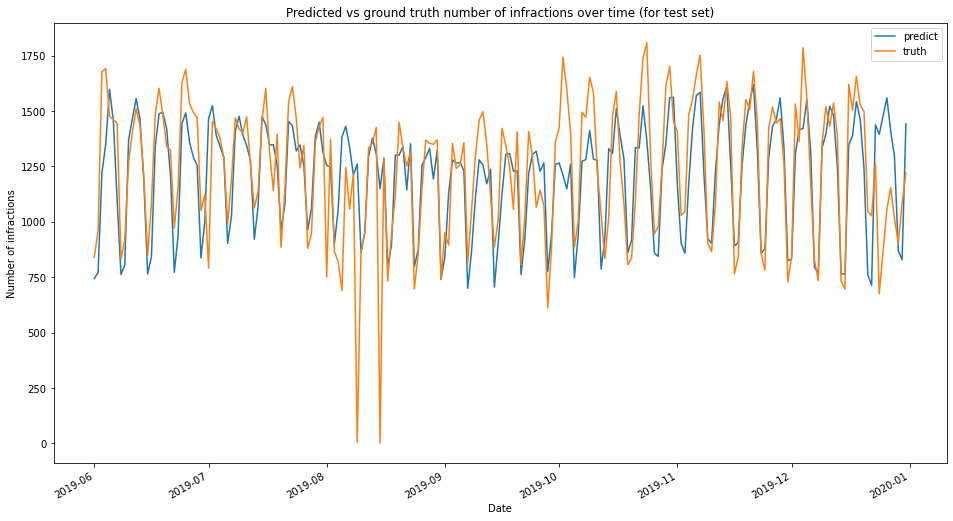

In [121]:
rms = np.sqrt(mean_squared_error(testDf["truth"], testDf["predict"]))
print ("Root mean Squared Error >> " + str(rms))
testDf.reset_index()
ax=testDf.plot(x="EntryDate", figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

ax.set_xlabel("Date")
ax.set_ylabel("Number of infractions")

By looking into the model predictions over a period of 7 Months one can observe that the Convolutional Neural Network is able to recognize patterns within each week. This is due to pattern repetition within each weekday over the year. Although some seasonal patterns might occur, the model only "looks" into the past 4 weekdays which will likely be similar to the current weekday. 

However, in some outlier cases like 2019-08-09 (Graduation day) or 2019-08-15 (National acadian day) the model was unable to make correct predictions and instead followed common patterns. Some strategies to deal with this problem include considering holidays as model features but from our experimentation no substantial gains were attained from such junction.

Increasing the date of prediction to more than one week (e.g., two weeks ahead, 4 weeks ahead) seamingly worsens the results due to the model being unable to predict future events with precision.

## Model predictions for December of 2019

Text(0, 0.5, 'Number of infractions')

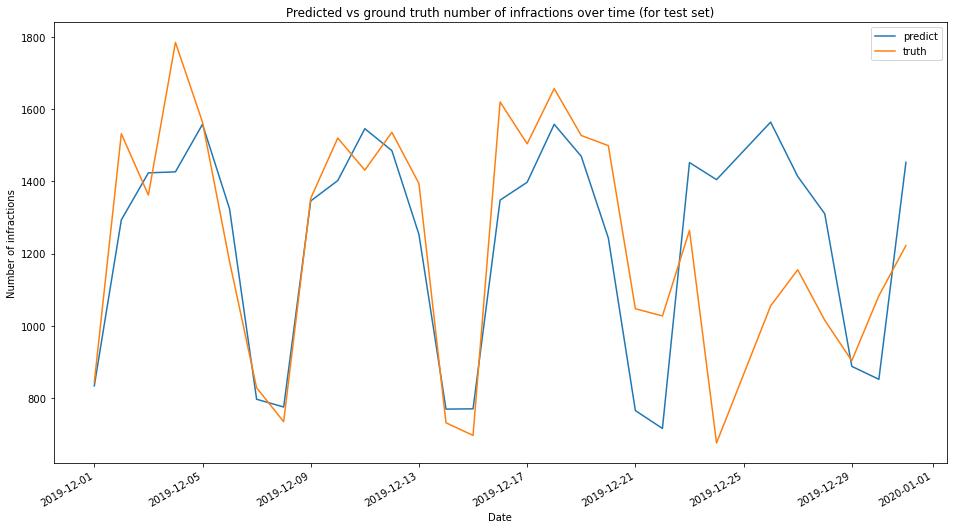

In [199]:
filteredTestDf=testDf[(testDf.EntryDate>="2019-12-01") & (testDf.EntryDate<="2019-12-31")]
pd.set_option('display.max_rows', testDf.shape[0]+1)

ax=filteredTestDf.plot(x="EntryDate", figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

ax.set_xlabel("Date")
ax.set_ylabel("Number of infractions")

If we take a look into the results over the period of 2019-12-01 to 2019-12-31 one can see that the model performs well enough on "normal" weeks but on outlier weeks such as the one from 2019-12-21 up until 2019-12-28 the model cannot predict such events as it only tries to infer this week's infractions based on the previous 4 weeks. Therefore, one point to be considered in future work is to determine ways to handle outlier days/weeks.

## Root Mean Squared Error for test set

In [123]:
rms = np.sqrt(mean_squared_error(filteredTestDf["truth"], filteredTestDf["predict"]))
rms

236.20327076928564

By comparing the CNN's results with methods such as ARIMA, SARIMA or ETS, one can observe that the RMSE (root mean squared error) is much lower on the neural network. This is likely related to <argumentos contra sarima, arima e ets>. 